Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu
    * czyta dane z Digital Ocean Spaces
    * czyści je
    * trenuje model (dobierz odpowiednie metryki [feature selection])
    * nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
    * opakuj model w aplikację streamlit
    * wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform 
    * wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
    jaka jest jego płeć, wiek i czas na 5km
    * jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
    * za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
    do określenia, do słownika (dictionary lub JSON)
    * tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a



In [1]:
import pandas as pd

# Load both years
df1 = pd.read_csv('halfmarathon_wroclaw_2023__final.csv', sep=';')
df2 = pd.read_csv('halfmarathon_wroclaw_2024__final.csv', sep=';')

# Add year as a column
df1["Rok"] = 2023
df2["Rok"] = 2024

# Merge them together
df_full = pd.concat([df1, df2], ignore_index=True)

# Save to a new file
df_full.to_csv('halfmarathon_wroclaw_2023_2024.csv', index=False, sep=';')

In [2]:
df_full.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo,Rok
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509,2023
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875,2023
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475,2023
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963,2023
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654,2023


In [3]:
pd.set_option('display.max_columns', None)
df_full.columns

Index(['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa',
       'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas',
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność',
       'Czas', 'Tempo', 'Rok'],
      dtype='object')

In [4]:
# Define your final selected columns
final_cols = [
    'Płeć',            # Gender
    'Rocznik',         # Year of birth → will convert to age later
    '5 km Czas',       # Main input feature
    'Tempo Stabilność',# Might be predictive, check datatype first
    'Czas',            # 🎯 Target: finish time
    'Rok'              # Just for now, we’ll remove before training
]

# Create a new DataFrame with only those columns
df_cleaned = df_full[final_cols]

In [5]:
df_cleaned.isna().sum()

Płeć                  11
Rocznik              485
5 km Czas           3546
Tempo Stabilność    3580
Czas                2055
Rok                    0
dtype: int64

In [6]:
df_cleaned = df_cleaned.dropna()
df_cleaned.isna().sum()

Płeć                0
Rocznik             0
5 km Czas           0
Tempo Stabilność    0
Czas                0
Rok                 0
dtype: int64

In [7]:
len(df_cleaned)

17895

In [8]:
df_cleaned.dtypes

Płeć                 object
Rocznik             float64
5 km Czas            object
Tempo Stabilność    float64
Czas                 object
Rok                   int64
dtype: object

In [9]:
df_cleaned['Płeć'].unique()
df_cleaned['Rocznik'].unique()
df_cleaned['5 km Czas'].head()
df_cleaned['Czas'].head()

0    01:04:59
1    01:06:23
2    01:08:24
3    01:10:16
4    01:10:27
Name: Czas, dtype: object

In [10]:
df_cleaned['Płeć'] = df_cleaned['Płeć'].str.upper()
df_cleaned['Płeć'] = df_cleaned['Płeć'].map({'M': 0, 'K': 1})

In [11]:
df_cleaned['Wiek'] = 2025 - df_cleaned['Rocznik'].astype(int)

In [12]:
df_cleaned.head()

,Płeć,Rocznik,5 km Czas,Tempo Stabilność,Czas,Rok,Wiek
0,0,1992.0,00:14:37,0.031400,01:04:59,2023,33
1,0,1986.0,00:14:48,0.038000,01:06:23,2023,39
2,0,1996.0,00:15:46,0.024067,01:08:24,2023,29
3,0,1988.0,00:16:11,0.025467,01:10:16,2023,37
4,0,1995.0,00:16:12,0.023000,01:10:27,2023,30


In [13]:
# Snippet - time into just seconds

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    if isinstance(time, (int, float)):
        return time
    time_parts = str(time).split(':')
    return int(time_parts[0]) * 3600 + int(time_parts[1]) * 60 + int(time_parts[2])


In [14]:
df_cleaned['5 km Czas'] = df_cleaned['5 km Czas'].apply(convert_time_to_seconds)
df_cleaned['Czas'] = df_cleaned['Czas'].apply(convert_time_to_seconds)

In [15]:
df_cleaned.head()

,Płeć,Rocznik,5 km Czas,Tempo Stabilność,Czas,Rok,Wiek
0,0,1992.0,877,0.031400,3899,2023,33
1,0,1986.0,888,0.038000,3983,2023,39
2,0,1996.0,946,0.024067,4104,2023,29
3,0,1988.0,971,0.025467,4216,2023,37
4,0,1995.0,972,0.023000,4227,2023,30


In [16]:
df_cleaned.drop(['Rocznik'], axis=1, inplace=True)
df_cleaned.head()

,Płeć,5 km Czas,Tempo Stabilność,Czas,Rok,Wiek
0,0,877,0.031400,3899,2023,33
1,0,888,0.038000,3983,2023,39
2,0,946,0.024067,4104,2023,29
3,0,971,0.025467,4216,2023,37
4,0,972,0.023000,4227,2023,30


In [17]:
df_cleaned.dtypes

Płeć                  int64
5 km Czas             int64
Tempo Stabilność    float64
Czas                  int64
Rok                   int64
Wiek                  int32
dtype: object

In [18]:
df_cleaned[df_cleaned['Płeć'] == 1].head()


,Płeć,5 km Czas,Tempo Stabilność,Czas,Rok,Wiek
14,1,1038,0.025533,4520,2023,30
24,1,1038,0.037400,4614,2023,40
47,1,1072,0.044800,4840,2023,35
89,1,1139,0.031933,4977,2023,32
131,1,1188,0.023600,5112,2023,24


In [19]:
df_cleaned.drop(columns='Rok', inplace=True)

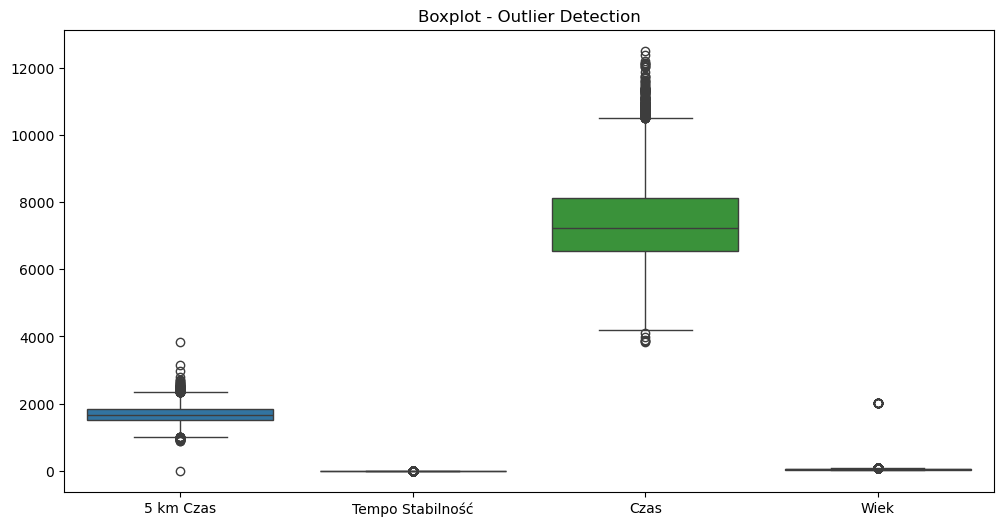

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[['5 km Czas', 'Tempo Stabilność', 'Czas', 'Wiek']])
plt.title("Boxplot - Outlier Detection")
plt.show()


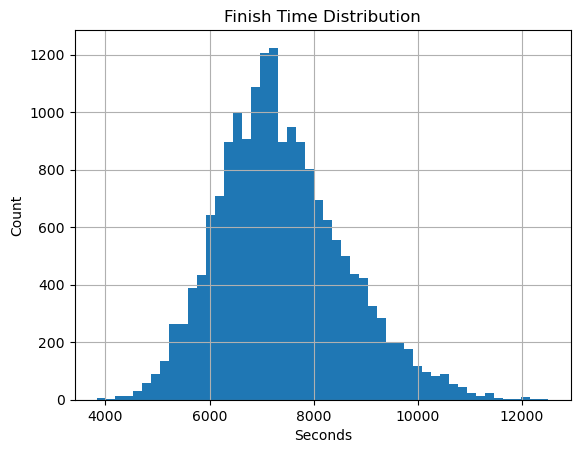

In [21]:
df_cleaned['Czas'].hist(bins=50)
plt.title('Finish Time Distribution')
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.show()


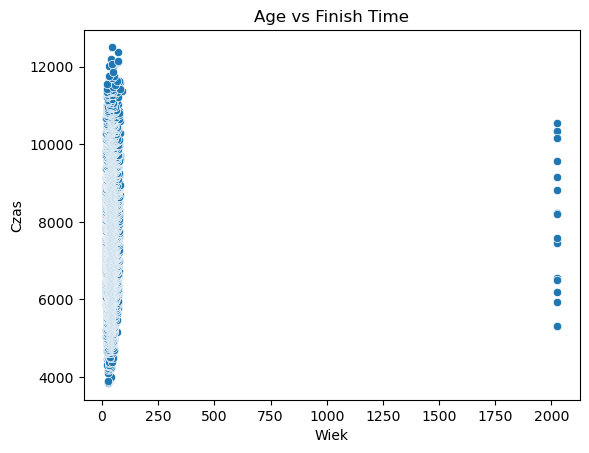

In [22]:
sns.scatterplot(x='Wiek', y='Czas', data=df_cleaned)
plt.title("Age vs Finish Time")
plt.show()


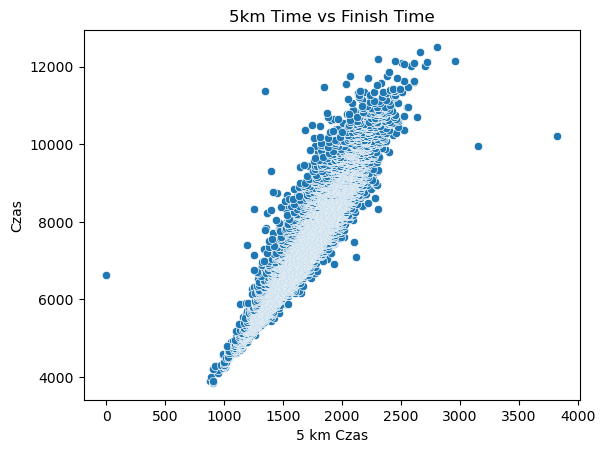

In [23]:
sns.scatterplot(x='5 km Czas', y='Czas', data=df_cleaned)
plt.title("5km Time vs Finish Time")
plt.show()

In [24]:
# IQR-based outlier removal for numerical columns
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in ['5 km Czas', 'Tempo Stabilność', 'Czas', 'Wiek']:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = df_cleaned[['Płeć', '5 km Czas', 'Tempo Stabilność', 'Wiek']]
y = df_cleaned['Czas']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'MAE: {mae:.2f} | RMSE: {rmse:.2f}')

MAE: 74.27 | RMSE: 105.87


In [30]:
df_cleaned['Czas'].describe()

count    16704.000000
mean      7254.969648
std       1071.047572
min       4377.000000
25%       6499.750000
50%       7170.500000
75%       7957.250000
max      10207.000000
Name: Czas, dtype: float64

In [32]:
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(model, "model.pkl")

['model.pkl']